# 基于InceptionV3的视网膜OCT图像水肿区域检测

本教程构建了一个基于深度学习框架的诊断工具，用于筛查常见且可治疗的致盲性视网膜疾病。该框架采用迁移学习技术，利用传统方法所需数据的一小部分即可训练神经网络。在光学相干断层扫描（OCT）图像数据集上，证明了其在分类年龄相关性黄斑变性（AMD）和糖尿病性黄斑水肿（DME）方面能够达到与人类专家相媲美的性能。此外，通过可视化神经网络关注的区域，提升了诊断的透明性和可解释性。我们还进一步验证了该人工智能系统在使用胸部 X 线图像诊断儿童肺炎方面的广泛适用性。该工具有望加速这些可治疗疾病的诊断与转诊，从而促进早期治疗并改善临床预后。

## 实验环境
本实验基于 MindSpore 框架，并使用 MindCV 套件中 InceptionV3 预训练模型，模型地址：https://github.com/mindspore-lab/mindcv/blob/main/mindcv/models/inceptionv3.py

软件环境：
* python==3.9.0
* mindspore==2.5.0
* mindcv==0.3.0

硬件环境：Ascend

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [3]:
# 安装mindcv
!pip install mindcv

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple/


## 数据集准备
该实验采用开源数据集OCT2017，数据集下载地址为：https://data.mendeley.com/datasets/rscbjbr9sj/2

该数据集包括四个类别：

* CNV：脉络膜血管新生（Choroidal neovascularization）
* DME：糖尿病黄斑水肿（Diabetic macular edema）
* DRUSEN：脉络膜玻璃膜疣
* NORMAL：正常

In [4]:
# 数据集下载
!wget --no-check-certificate https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/5699a1d8-d1b6-45db-bb92-b61051445347/file_downloaded -O ./OCT2017.tar.gz

--2025-03-26 09:01:42--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/5699a1d8-d1b6-45db-bb92-b61051445347/file_downloaded
正在解析主机 data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
正在连接 data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 302 Found
位置：https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/9cfd5550-a37d-4404-9441-860ee091bc67 [跟随至新的 URL]
--2025-03-26 09:01:45--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/9cfd5550-a37d-4404-9441-860ee091bc67
正在解析主机 prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.66.218, 3.5.67.71, 3.5.66.113, ...
正在连接 prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.66.218|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：5793183169 (5.4G) [appl

In [5]:
# 解压数据集
!tar -zxvf OCT2017.tar.gz > /dev/null 2>&1

### 验证集构建
从指定的“train”和“test”数据集中各随机抽取 10% 的图像，移动至新的“val”目录，以构建验证集。


In [6]:
import os
import shutil
import random

random.seed(42)  # 固定随机种子，确保结果可复现

dataset_path = "./OCT2017"  # 数据集根目录
train_folder = os.path.join(dataset_path, "train")
test_folder = os.path.join(dataset_path, "test")
val_folder = os.path.join(dataset_path, "val")

categories = ["CNV", "DME", "DRUSEN", "NORMAL"]

# 创建 val 文件夹及各类别子文件夹
if not os.path.exists(val_folder):
    os.mkdir(val_folder)
for cat in categories:
    cat_val_folder = os.path.join(val_folder, cat)
    if not os.path.exists(cat_val_folder):
        os.mkdir(cat_val_folder)

# 设定从 train 和 test 目录分别抽取 10% 的数据到 val
total_move_ratio = 0.2  # 总共 20% 的数据
train_move_ratio = 0.1   # 10% 来自 train
test_move_ratio = 0.1    # 10% 来自 test

def move_images(source_folder, dest_folder, category, ratio):
    source_cat_folder = os.path.join(source_folder, category)
    dest_cat_folder = os.path.join(dest_folder, category)
    
    if not os.path.exists(source_cat_folder):
        print(f"警告: {source_cat_folder} 不存在，跳过。")
        return
    
    files = [f for f in os.listdir(source_cat_folder) if f.lower().endswith(('.jpeg', '.jpg'))]
    num_to_move = int(len(files) * ratio)
    files_to_move = random.sample(files, num_to_move) if num_to_move > 0 else []
    
    for file in files_to_move:
        src_file = os.path.join(source_cat_folder, file)
        dst_file = os.path.join(dest_cat_folder, file)
        shutil.move(src_file, dst_file)
        # print(f"Moved {src_file} to {dst_file}")

# 从 train 和 test 目录中分别抽取部分数据
for cat in categories:
    move_images(train_folder, val_folder, cat, train_move_ratio)
    move_images(test_folder, val_folder, cat, test_move_ratio)

print("val 数据集构建完成。")

val 数据集构建完成。


## 训练与工具函数准备

本模块提供了一系列工具函数，主要用于数据集管理、图像预处理、模型权重下载与保存、日志目录创建以及 ROC 曲线生成等操作。

In [7]:
import sys
import os
from glob import glob
from six.moves import urllib
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from mindspore import Tensor
import mindspore.common.dtype as mstype


# 如果目录不存在则创建目录
def create_directory(dir_path):
    os.makedirs(dir_path, exist_ok=True)

# 获取指定目录下所有 .jpeg 文件的文件名列表，并排序返回
def get_image_files(image_dir):
    fs = glob("{}/*.jpeg".format(image_dir))
    fs = [os.path.basename(filename) for filename in fs]
    return sorted(fs)

# 根据真实标签和预测得分生成并绘制 ROC 曲线，同时返回 AUC 值
def generate_roc(y_test, y_score, pos_label=0):
    from sklearn.metrics import roc_curve, auc
    # 计算 FPR 和 TPR
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=pos_label)
    # 计算 AUC 值
    roc_auc = auc(fpr, tpr)
    plt.figure()
     # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    # 绘制参考直线
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic curve")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

# 下载预训练权重文件（若 URL 不为空），并将其解压到目标目录中
def download_pretrained_weights(inception_url, dest_dir):
    if not inception_url:
        return
    create_directory(dest_dir)
    filename = inception_url.split("/")[-1]
    filepath = os.path.join(dest_dir, filename)
    # 若文件不存在则下载
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write("\r>> Downloading {} {:0.1f}%".format(
                filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(inception_url, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print("Successfully downloaded {} {} bytes.".format(filename, statinfo.st_size))
        tarfile.open(filepath, "r:gz").extractall(dest_dir)

# 保存模型到 ckpt 文件（MindSpore 格式）
def save_model(model, output_file, final_tensor_name):
    from mindspore.train.serialization import save_checkpoint
    ckpt_file = output_file + ".ckpt"
    save_checkpoint(model, ckpt_file)
    print("Checkpoint saved to", ckpt_file)

# 根据数据集目录生成训练、测试和验证集的图像列表（以字典形式返回）    
def create_image_lists(image_dir):
    result = {}
    training_images = []
    testing_images = []
    validation_images = []
    
    # 遍历 train、test 和 val 目录
    for category in ["train", "test", "val"]:
        category_path = os.path.join(image_dir, category)
        try:
            bins = next(os.walk(category_path))[1] # 获取子目录名称（即各类别）
        except StopIteration:
            sys.exit("ERROR: Missing either train/test/val folders in image_dir")
            
        # 对每个类别收集图像文件名列表
        for diagnosis in bins:
            bin_path = os.path.join(category_path, diagnosis)
            if category == "train":
                training_images.append(get_image_files(bin_path))
            if category == "test":
                testing_images.append(get_image_files(bin_path))
            if category == "val":
                validation_images.append(get_image_files(bin_path))
                
    # 构造结果字典，键为类别名称，值为各类别在训练、测试和验证集中的图像列表
    for diagnosis in bins:
        result[diagnosis] = {
            "training": training_images[bins.index(diagnosis)],
            "testing": testing_images[bins.index(diagnosis)],
            "validation": validation_images[bins.index(diagnosis)],
        }
    return result

# 获取指定类别及索引图像的完整路径
def get_image_path(image_lists, label_name, index, image_dir, category):
    if label_name not in image_lists:
        raise ValueError("Label does not exist: {}".format(label_name))
    label_lists = image_lists[label_name]
    if category not in label_lists:
        raise ValueError("Category does not exist: {}".format(category))
    category_list = label_lists[category]
    if not category_list:
        raise ValueError("Label {} has no images in the category {}.".format(label_name, category))
    mod_index = index % len(category_list)
    base_name = category_list[mod_index]
    
     # 根据不同类别构造完整路径
    if "train" in category:
        full_path = os.path.join(image_dir, "train", label_name.upper(), base_name)
    elif "test" in category:
        full_path = os.path.join(image_dir, "test", label_name.upper(), base_name)
    elif "val" in category:
        full_path = os.path.join(image_dir, "val", label_name.upper(), base_name)
    return full_path

# 构造图像对应的瓶颈特征文件路径（附加特定后缀）
def get_bottleneck_path(image_lists, label_name, index, bottleneck_dir, category):
    return get_image_path(image_lists, label_name, index, bottleneck_dir, category) + "_inception_v3.txt"

# 创建（或重建）用于 TensorBoard 的日志目录
def create_tensorboard_directories(summaries_dir):
    if os.path.exists(summaries_dir):
        import shutil
        shutil.rmtree(summaries_dir)
    os.makedirs(summaries_dir)

# 返回 JPEG 解码函数，用于将图像转换为固定尺寸、归一化的数组
def decode_jpeg(input_width, input_height, input_depth, input_mean, input_std):
    from PIL import Image
    def decode_image_file(image_path):
        img = Image.open(image_path)
        img = img.convert("RGB")
        img = img.resize((input_width, input_height))
        img_array = np.array(img).astype(np.float32)
         # 归一化处理
        img_array = (img_array - input_mean) / input_std
        # 转换通道顺序
        img_array = np.transpose(img_array, (2, 0, 1))
        return img_array
    return decode_image_file, decode_image_file

# 直接读取图像文件并转换为指定尺寸的数组
def decode_image(image_path, target_size):
    from PIL import Image
    img = Image.open(image_path)
    img = img.convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32)
    img_array = np.transpose(img_array, (2, 0, 1))
    return img_array

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### 构造训练函数
基于 MindSpore 框架加载 InceptionV3 预训练模型，提取瓶颈特征，并训练最终分类层。
#### 主要功能：
1. 模型配置：定义 InceptionV3 相关的参数，如输入尺寸、归一化参数等。
2. 瓶颈特征提取：使用 InceptionV3 提取图像的瓶颈特征，并存储到本地。
3. 数据处理：支持批量存储和读取瓶颈特征。
4. 分类层训练：定义一个全连接层，使用瓶颈特征进行分类训练。

5.模型评估：计算模型的分类准确率。

### 关键步骤

1.加载 InceptionV3 预训练模型

2.定义瓶颈特征提取流程

3.存储和管理瓶颈特征

4.训练最终分类层
5. 使用瓶颈特征进行批量训练
6. 模型评估，计算准确率

In [10]:
import os
import random
import numpy as np
import mindspore as ms
import mindspore.nn as nn
from mindspore import Tensor
import mindspore.common.dtype as mstype

# 获取 InceptionV3 模型的相关配置参数
def get_model_config():
    # 使用 mindcv 的 InceptionV3 模型
    inception_url = ""  # 预训练模型的下载地址（如果有的话）
    bottleneck_tensor_size = 2048   # InceptionV3 瓶颈层特征向量的大小
    input_width = 299   # 输入图像的宽度
    input_height = 299  # 输入图像的高度
    input_depth = 3  # 输入图像的通道数（RGB）
    model_file_name = "inception_v3.ms"  # 预训练模型文件名
    input_mean = 128  # 归一化时的均值
    input_std = 128  # 归一化时的标准差
    return {
        "inception_url": inception_url,
        "bottleneck_tensor_size": bottleneck_tensor_size,
        "input_width": input_width,
        "input_height": input_height,
        "input_depth": input_depth,
        "model_file_name": model_file_name,
        "input_mean": input_mean,
        "input_std": input_std,
    }

# 使用模型计算图像的瓶颈特征
def run_bottleneck_on_image(model, image_data):
    features = model(image_data)  # 通过模型提取特征
    features = features.asnumpy().squeeze()  # 转换为 numpy 数组并去除多余维度
    return features

# 生成并保存瓶颈特征
def create_bottleneck(bottleneck_path, image_path, model):
    # print("Creating Bottleneck at {}".format(bottleneck_path))
    # 利用 decode_image 解码图像
    img = decode_image(image_path, target_size=(get_model_config()["input_height"], get_model_config()["input_width"]))
    bottleneck_values = run_bottleneck_on_image(model, Tensor(np.expand_dims(img, axis=0).astype(np.float32)))
    bottleneck_string = ",".join(str(x) for x in bottleneck_values)
    # 创建目录（如果不存在）
    bottleneck_dir = os.path.dirname(bottleneck_path)
    os.makedirs(bottleneck_dir, exist_ok=True)
    # 将瓶颈特征写入文件
    with open(bottleneck_path, "w") as f:
        f.write(bottleneck_string)

# 读取或创建瓶颈特征
def get_bottleneck(model, image_lists, label_name, index, image_dir, category, bottleneck_dir):
    bottleneck_path = get_bottleneck_path(image_lists, label_name, index, bottleneck_dir, category)
    # 如果瓶颈文件不存在，则创建它
    if not os.path.exists(bottleneck_path):
        image_path = get_image_path(image_lists, label_name, index, image_dir, category)
        create_bottleneck(bottleneck_path, image_path, model)
    # 读取瓶颈文件
    with open(bottleneck_path, "r") as f:
        bottleneck_string = f.read()
    try:
        bottleneck_values = [float(x) for x in bottleneck_string.split(",")]
    except ValueError:
        # 如果读取失败，则重新创建瓶颈文件
        print("Error reading bottleneck, recreating bottleneck")
        image_path = get_image_path(image_lists, label_name, index, image_dir, category)
        create_bottleneck(bottleneck_path, image_path, model)
        with open(bottleneck_path, "r") as f:
            bottleneck_string = f.read()
        bottleneck_values = [float(x) for x in bottleneck_string.split(",")]
    return bottleneck_values

# 生成并存储所有瓶颈特征
def store_bottlenecks(model, image_lists, image_dir, bottleneck_dir, jpeg_decoder, decoded_image_func, resized_image_processor):
    num_bottlenecks = 0
    os.makedirs(bottleneck_dir, exist_ok=True)
    for label_name, label_lists in image_lists.items():
        for category in label_lists:  # 直接遍历 training, testing, validation
            for index, _ in enumerate(label_lists[category]):
                get_bottleneck(model, image_lists, label_name, index, image_dir, category, bottleneck_dir)
                num_bottlenecks += 1
            # if num_bottlenecks % 1000 == 0:
            #     print("{} bottleneck files created.".format(num_bottlenecks))
    print(f"Bottleneck feature extraction completed. Total: {num_bottlenecks} files.")

# 定义最终的全连接分类层
def train_final_layer(class_count, final_tensor_name, bottleneck_model, bottleneck_tensor_size, learning_rate):
    class FinalLayer(nn.Cell):
        def __init__(self, bottleneck_tensor_size, class_count):
            super(FinalLayer, self).__init__()
            self.fc = nn.Dense(
                in_channels=bottleneck_tensor_size,
                out_channels=class_count,
                dtype=mstype.float32
            )
        def construct(self, x):
            x = x.astype(np.float32)
            x = x.view(-1, self.fc.in_channels)
            return self.fc(x)
    final_layer = FinalLayer(bottleneck_tensor_size, class_count)
    loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=False, reduction="mean")
    optimizer = nn.Adam(final_layer.trainable_params(), learning_rate=learning_rate)
    return final_layer, loss_fn, optimizer

# 创建评估计算图
def create_evaluation_graph(final_layer, ground_truth_tensor):
    evaluation_metric = nn.Accuracy()
    return evaluation_metric

# 构建 InceptionV3 相关的计算图
def create_model_graph(model_config, model_dir):
    from mindcv.models import inception_v3
    pretrained_model = inception_v3(num_classes=1000, pretrained=True)
    
    # 定义瓶颈特征提取器
    class BottleneckExtractor(nn.Cell):
        def __init__(self, model):
            super(BottleneckExtractor, self).__init__()
            self.model = model
        def construct(self, x):
            x = self.model.forward_preaux(x)
            x = self.model.forward_postaux(x)
            x = self.model.pool(x)
            x = self.model.dropout(x)
            return x
    bottleneck_extractor = BottleneckExtractor(pretrained_model)
    
    # 图像预处理
    def resized_image_processor(image):
        from mindspore.dataset.vision import vision
        resize = vision.Resize((model_config["input_height"], model_config["input_width"]))
        return resize(image)
    return pretrained_model, bottleneck_extractor, resized_image_processor

# 获取批量存储的瓶颈特征
def get_batch_of_stored_bottlenecks(image_lists, batch_size, category, bottleneck_dir, image_dir, jpeg_decoder, decoded_image_func, resized_image_processor, bottleneck_model):
    MAX_NUM_IMAGES_PER_CLASS = 2**27 - 1
    class_count = len(image_lists.keys())
    bottlenecks = []
    ground_truths = []
    filenames = []
    if batch_size >= 0:
        for i in range(batch_size):
            label_index = random.randrange(class_count)
            label_name = list(image_lists.keys())[label_index]
            image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
            image_name = get_image_path(image_lists, label_name, image_index, image_dir, category)
            bottleneck = get_bottleneck(bottleneck_model, image_lists, label_name, image_index, image_dir, category, bottleneck_dir)
            ground_truth = np.zeros(class_count, dtype=np.float32)
            ground_truth[label_index] = 1
            bottlenecks.append(bottleneck)
            ground_truths.append(ground_truth)
            filenames.append(image_name)
    else:
        for label_index, label_name in enumerate(image_lists.keys()):
            for image_index, image_name in enumerate(image_lists[label_name][category]):
                image_name = get_image_path(image_lists, label_name, image_index, image_dir, category)
                bottleneck = get_bottleneck(bottleneck_model, image_lists, label_name, image_index, image_dir, category, bottleneck_dir)
                ground_truth = np.zeros(class_count, dtype=np.float32)
                ground_truth[label_index] = 1.0
                bottlenecks.append(bottleneck)
                ground_truths.append(ground_truth)
                filenames.append(image_name)
    return np.array(bottlenecks), np.array(ground_truths), filenames

# 创建 MindSpore 数据集
def get_dataset_from_bottlenecks(bottlenecks, ground_truth):
    import mindspore.dataset as ds
    dataset = ds.NumpySlicesDataset({"bottleneck": bottlenecks, "label": ground_truth}, shuffle=True)
    dataset = dataset.batch(bottlenecks.shape[0])
    return dataset

# 评估模型
def evaluate_model(bottlenecks, ground_truth, final_layer, evaluation_metric, return_details=False):
    bottlenecks_tensor = Tensor(bottlenecks.astype(np.float32))
    logits = final_layer(bottlenecks_tensor)
    predictions = logits.asnumpy()
    true_labels = np.argmax(ground_truth, axis=1)
    accuracy = evaluation_metric(Tensor(predictions), Tensor(true_labels))
    if return_details:
        return accuracy, predictions, predictions
    else:
        return accuracy, np.mean(logits.asnumpy())

## 视网膜 OCT 图像分类训练流程

### 1. 设置参数和环境
- 通过 `FLAGS` 类定义数据路径和训练参数（学习率、训练步数、批次大小等）。
- 设置 MindSpore 运行环境为 Ascend 设备的图模式（`GRAPH_MODE`）。

### 2. 初始化与数据准备
- 创建 TensorBoard 相关目录并打开日志文件。
- 下载预训练模型（如 Inception），并加载用于瓶颈特征提取的网络。
- 读取数据集，构建 `image_lists`，确保数据包含多个类别。
- 预计算瓶颈特征（加速训练），并保存到 `bottleneck_dir`。

### 3. 构建训练模型
- 定义最终分类层，设置损失函数和优化器。
- 通过 `MindSpore Model` 组织训练流程，并添加准确率评估指标。

### 4. 模型训练
- 进行 `training_steps` 轮训练，每 `eval_frequency` 轮评估一次训练和验证集的准确率。
- 选择最佳验证准确率的模型进行保存。

### 5. 模型测试
- 使用测试集数据评估最终模型，并计算测试准确率。
- 记录训练总耗时。

### 6. 计算 AUC
- 计算 ROC 曲线，并计算 AUC 作为最终评估指标。

本流程涵盖了数据预处理、模型训练、评估与测试，并记录关键日志。


[WARNING] ME(546:281473066278944,MainProcess):2025-03-26-10:49:40.635.101 [mindspore/context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


Logging: INFO
category: training
category: testing
category: validation
category: training
category: testing
category: validation
category: training
category: testing
category: validation
category: training
category: testing
category: validation
Bottleneck feature extraction completed. Total: 84478 files.


Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

.

Training Progress:   0%|          | 1/5000 [00:11<15:36:47, 11.24s/it]

.Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 0: loss = -0.4259214699268341 train acc = 0.29296875 val acc = 0.13293838862559243


Training Progress:   2%|▏         | 101/5000 [00:50<4:08:38,  3.05s/it]

Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 100: loss = -0.5180859565734863 train acc = 0.5390625 val acc = 0.5921800947867298


Training Progress:   4%|▍         | 201/5000 [01:26<4:00:12,  3.00s/it]

Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 200: loss = -0.5722171068191528 train acc = 0.5625 val acc = 0.6527251184834123


Training Progress:   6%|▌         | 301/5000 [02:03<4:06:33,  3.15s/it]

Step 300: loss = -0.589460015296936 train acc = 0.55859375 val acc = 0.6151658767772512


Training Progress:   8%|▊         | 401/5000 [02:42<4:18:43,  3.38s/it]

Step 400: loss = -0.6498240828514099 train acc = 0.65234375 val acc = 0.6244075829383886


Training Progress:  10%|█         | 501/5000 [03:21<3:56:09,  3.15s/it]

Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 500: loss = -0.6581562757492065 train acc = 0.66015625 val acc = 0.6741706161137441


Training Progress:  12%|█▏        | 601/5000 [04:00<4:20:11,  3.55s/it]

Step 600: loss = -0.6841924786567688 train acc = 0.65234375 val acc = 0.6221563981042654


Training Progress:  14%|█▍        | 701/5000 [04:43<4:03:32,  3.40s/it]

Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 700: loss = -0.6976674199104309 train acc = 0.6484375 val acc = 0.6970379146919431


Training Progress:  16%|█▌        | 801/5000 [05:21<3:36:39,  3.10s/it]

Step 800: loss = -0.7109523415565491 train acc = 0.671875 val acc = 0.6937203791469194


Training Progress:  18%|█▊        | 901/5000 [05:59<3:28:02,  3.05s/it]

Step 900: loss = -0.7214579582214355 train acc = 0.61328125 val acc = 0.695260663507109


Training Progress:  20%|██        | 1001/5000 [06:36<3:20:42,  3.01s/it]

Step 1000: loss = -0.7293553352355957 train acc = 0.72265625 val acc = 0.6617298578199052


Training Progress:  22%|██▏       | 1101/5000 [07:13<3:39:40,  3.38s/it]

Step 1100: loss = -0.7535486221313477 train acc = 0.66796875 val acc = 0.678436018957346


Training Progress:  24%|██▍       | 1201/5000 [07:53<3:25:01,  3.24s/it]

Step 1200: loss = -0.7552632093429565 train acc = 0.67578125 val acc = 0.623696682464455


Training Progress:  26%|██▌       | 1301/5000 [08:29<3:06:03,  3.02s/it]

Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 1300: loss = -0.7407332062721252 train acc = 0.734375 val acc = 0.7085308056872038


Training Progress:  28%|██▊       | 1401/5000 [09:05<3:00:41,  3.01s/it]

Step 1400: loss = -0.7574417591094971 train acc = 0.70703125 val acc = 0.7005924170616113


Training Progress:  30%|███       | 1501/5000 [09:46<3:18:47,  3.41s/it]

Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 1500: loss = -0.7459719777107239 train acc = 0.6953125 val acc = 0.7124407582938389


Training Progress:  32%|███▏      | 1601/5000 [10:24<2:50:48,  3.02s/it]

Step 1600: loss = -0.785544753074646 train acc = 0.73828125 val acc = 0.658649289099526


Training Progress:  34%|███▍      | 1701/5000 [11:04<2:50:24,  3.10s/it]

Step 1700: loss = -0.7912619709968567 train acc = 0.640625 val acc = 0.6438388625592417


Training Progress:  36%|███▌      | 1801/5000 [11:41<2:44:36,  3.09s/it]

Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 1800: loss = -0.7687326073646545 train acc = 0.6953125 val acc = 0.7135071090047393


Training Progress:  38%|███▊      | 1901/5000 [12:18<2:37:50,  3.06s/it]

Step 1900: loss = -0.8033512830734253 train acc = 0.65234375 val acc = 0.6503554502369668


Training Progress:  40%|████      | 2001/5000 [12:55<2:32:07,  3.04s/it]

Step 2000: loss = -0.7780830264091492 train acc = 0.6953125 val acc = 0.6981042654028436


Training Progress:  42%|████▏     | 2101/5000 [13:33<2:52:23,  3.57s/it]

Step 2100: loss = -0.7909393310546875 train acc = 0.671875 val acc = 0.6712085308056872


Training Progress:  44%|████▍     | 2201/5000 [14:11<2:37:40,  3.38s/it]

Step 2200: loss = -0.8078173398971558 train acc = 0.65625 val acc = 0.7018957345971564


Training Progress:  46%|████▌     | 2301/5000 [14:51<2:24:23,  3.21s/it]

Step 2300: loss = -0.8154083490371704 train acc = 0.6796875 val acc = 0.6936018957345972


Training Progress:  48%|████▊     | 2401/5000 [15:29<2:13:40,  3.09s/it]

Step 2400: loss = -0.8079195022583008 train acc = 0.65234375 val acc = 0.7111374407582939


Training Progress:  50%|█████     | 2501/5000 [16:07<2:07:33,  3.06s/it]

Step 2500: loss = -0.8302124738693237 train acc = 0.6640625 val acc = 0.658649289099526


Training Progress:  52%|█████▏    | 2601/5000 [16:44<2:00:22,  3.01s/it]

Step 2600: loss = -0.8212428689002991 train acc = 0.6953125 val acc = 0.7117298578199052


Training Progress:  54%|█████▍    | 2701/5000 [17:20<1:54:47,  3.00s/it]

Step 2700: loss = -0.8195911049842834 train acc = 0.67578125 val acc = 0.6859004739336493


Training Progress:  56%|█████▌    | 2801/5000 [17:57<1:49:11,  2.98s/it]

Checkpoint saved to /home/mindspore/work/MS_Demo/retrained_model.ckpt
Step 2800: loss = -0.8146654367446899 train acc = 0.66796875 val acc = 0.7522511848341232


Training Progress:  58%|█████▊    | 2901/5000 [18:33<1:43:37,  2.96s/it]

Step 2900: loss = -0.8508992791175842 train acc = 0.6953125 val acc = 0.6855450236966825


Training Progress:  60%|██████    | 3001/5000 [19:12<2:18:10,  4.15s/it]

Step 3000: loss = -0.8546663522720337 train acc = 0.69921875 val acc = 0.7079383886255924


Training Progress:  62%|██████▏   | 3101/5000 [19:54<1:45:42,  3.34s/it]

Step 3100: loss = -0.8476408123970032 train acc = 0.66796875 val acc = 0.6977488151658767


Training Progress:  64%|██████▍   | 3201/5000 [20:33<1:32:00,  3.07s/it]

Step 3200: loss = -0.8401472568511963 train acc = 0.66015625 val acc = 0.7056872037914692


Training Progress:  66%|██████▌   | 3301/5000 [21:10<1:24:40,  2.99s/it]

Step 3300: loss = -0.8411237001419067 train acc = 0.6796875 val acc = 0.7059241706161138


Training Progress:  68%|██████▊   | 3401/5000 [21:47<1:18:37,  2.95s/it]

Step 3400: loss = -0.8469817638397217 train acc = 0.72265625 val acc = 0.7058056872037914


Training Progress:  70%|███████   | 3501/5000 [22:23<1:14:13,  2.97s/it]

Step 3500: loss = -0.8642721176147461 train acc = 0.6796875 val acc = 0.6645734597156399


Training Progress:  72%|███████▏  | 3601/5000 [22:59<1:10:14,  3.01s/it]

Step 3600: loss = -0.8580228090286255 train acc = 0.7578125 val acc = 0.6960900473933649


Training Progress:  74%|███████▍  | 3701/5000 [23:35<1:05:34,  3.03s/it]

Step 3700: loss = -0.8697911500930786 train acc = 0.68359375 val acc = 0.7245260663507109


Training Progress:  76%|███████▌  | 3801/5000 [24:12<1:07:12,  3.36s/it]

Step 3800: loss = -0.8765966892242432 train acc = 0.71875 val acc = 0.7138625592417062


Training Progress:  78%|███████▊  | 3901/5000 [24:52<55:32,  3.03s/it]  

Step 3900: loss = -0.8734250664710999 train acc = 0.69140625 val acc = 0.6559241706161137


Training Progress:  80%|████████  | 4001/5000 [25:30<49:56,  3.00s/it]

Step 4000: loss = -0.862900972366333 train acc = 0.66015625 val acc = 0.6753554502369669


Training Progress:  82%|████████▏ | 4101/5000 [26:06<43:46,  2.92s/it]

Step 4100: loss = -0.868788480758667 train acc = 0.73046875 val acc = 0.7228672985781991


Training Progress:  84%|████████▍ | 4201/5000 [26:44<44:05,  3.31s/it]

Step 4200: loss = -0.887825608253479 train acc = 0.6875 val acc = 0.6972748815165877


Training Progress:  86%|████████▌ | 4301/5000 [27:20<34:54,  3.00s/it]

Step 4300: loss = -0.8766358494758606 train acc = 0.7109375 val acc = 0.709478672985782


Training Progress:  88%|████████▊ | 4401/5000 [27:56<29:37,  2.97s/it]

Step 4400: loss = -0.8725025653839111 train acc = 0.6796875 val acc = 0.7270142180094786


Training Progress:  90%|█████████ | 4501/5000 [28:32<24:46,  2.98s/it]

Step 4500: loss = -0.8781546950340271 train acc = 0.75390625 val acc = 0.7336492890995261


Training Progress:  92%|█████████▏| 4601/5000 [29:08<20:54,  3.14s/it]

Step 4600: loss = -0.8772099018096924 train acc = 0.703125 val acc = 0.7330568720379147


Training Progress:  94%|█████████▍| 4701/5000 [29:48<16:38,  3.34s/it]

Step 4700: loss = -0.8796604871749878 train acc = 0.6953125 val acc = 0.7439573459715639


Training Progress:  96%|█████████▌| 4801/5000 [30:26<09:50,  2.97s/it]

Step 4800: loss = -0.8967849016189575 train acc = 0.703125 val acc = 0.7091232227488151


Training Progress:  98%|█████████▊| 4901/5000 [31:03<04:51,  2.95s/it]

Step 4900: loss = -0.8914527893066406 train acc = 0.6796875 val acc = 0.6971563981042654


Training Progress: 100%|██████████| 5000/5000 [31:39<00:00,  2.63it/s]

Step 4999: loss = -0.8778105974197388 train acc = 0.6875 val acc = 0.7438388625592417


.Best validation accuracy = 75.22511848341232
Final test accuracy = 83.11111111111111
总推理时间: 0.26 秒
每张图片的平均推理时间: 0.0003 秒
Total Model Runtime: 31min, 41.21sec


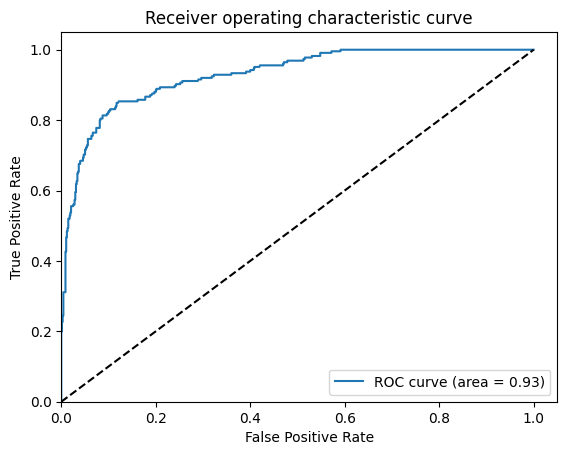

Final Model AUC: 92.85%


In [12]:
import os
import sys
import time
import numpy as np
import mindspore as ms
from mindspore import context
from tqdm import tqdm

# 在 Notebook 中直接定义参数，不使用命令行参数
class FLAGS:
    images = "/home/mindspore/work/OCT2017"
    output_graph = "/home/mindspore/work/MS_Demo/retrained_model"
    output_labels = "/home/mindspore/work/MS_Demo/output_labels.txt"
    summaries_dir = "/home/mindspore/work/MS_Demo/retrain_logs"
    training_steps = 5000
    learning_rate = 0.001
    eval_frequency = 100
    train_batch_size = 256
    test_batch_size = -1
    validation_batch_size = -1
    model_dir = "/home/mindspore/work/MS_Demo/imagenet"
    bottleneck_dir = "/home/mindspore/work/MS_Demo/bottleneck"
    final_tensor_name = "final_result"

# 设置 MindSpore 运行环境
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")
print("Logging: INFO")

# 创建日志目录，并打开日志文件
create_tensorboard_directories(FLAGS.summaries_dir)
log_file_path = os.path.join(FLAGS.summaries_dir, "training.log")
log_file = open(log_file_path, "w")

# 设置模型参数
model_config = get_model_config()

# 如果 inception_url 非空，则下载预训练权重
if model_config.get("inception_url"):
    download_pretrained_weights(model_config["inception_url"], FLAGS.model_dir)

# 加载预训练模型并构造瓶颈提取器与图像预处理函数
pretrained_model, bottleneck_extractor, resized_image_processor = create_model_graph(model_config, FLAGS.model_dir)

# 构建所有图像的列表
image_lists = create_image_lists(FLAGS.images)
class_count = len(image_lists.keys())
if class_count == 0:
    print("ERROR: No valid folders of images found at " + FLAGS.images)
    sys.exit(-1)
if class_count == 1:
    print("ERROR: Only one valid folder of images found at " + FLAGS.images + " - multiple classes are needed for classification.")
    sys.exit(-1)

# 写出标签文件
with open(FLAGS.output_labels, "w") as f:
    f.write("\n".join(image_lists.keys()) + "\n")

# 设置图像解码函数
jpeg_decoder, decoded_image_func = decode_jpeg(
    model_config["input_width"], model_config["input_height"],
    model_config["input_depth"], model_config["input_mean"],
    model_config["input_std"]
)

# 预先计算并保存瓶颈特征
store_bottlenecks(bottleneck_extractor, image_lists, FLAGS.images, FLAGS.bottleneck_dir,
                  jpeg_decoder, decoded_image_func, resized_image_processor)

# 训练最终分类层
final_layer, loss_fn, optimizer = train_final_layer(
    len(image_lists.keys()), FLAGS.final_tensor_name, bottleneck_extractor,
    model_config["bottleneck_tensor_size"], FLAGS.learning_rate
)

# 创建评估指标
evaluation_metric = create_evaluation_graph(final_layer, None)

# 构造 MindSpore Model
final_model = ms.Model(final_layer, loss_fn=loss_fn, optimizer=optimizer, metrics={"Accuracy": ms.nn.Accuracy()})

best_acc = 0.0
since = time.time()

# 训练循环
# for i in range(FLAGS.training_steps):
for i in tqdm(range(FLAGS.training_steps), desc="Training Progress"):
    # 获取训练阶段的瓶颈特征
    train_bottlenecks, train_ground_truth, _ = get_batch_of_stored_bottlenecks(
        image_lists, FLAGS.train_batch_size, "training",
        FLAGS.bottleneck_dir, FLAGS.images, jpeg_decoder,
        decoded_image_func, resized_image_processor, bottleneck_extractor
    )
    train_dataset = get_dataset_from_bottlenecks(train_bottlenecks, train_ground_truth)
    final_model.train(1, train_dataset=train_dataset, dataset_sink_mode=False)
    final_step = (i + 1 == FLAGS.training_steps)
    if (i % FLAGS.eval_frequency == 0) or final_step:
        train_accuracy, ce_value = evaluate_model(train_bottlenecks, train_ground_truth, final_layer, evaluation_metric)
        validation_bottlenecks, validation_ground_truth, _ = get_batch_of_stored_bottlenecks(
            image_lists, FLAGS.validation_batch_size, "validation",
            FLAGS.bottleneck_dir, FLAGS.images, jpeg_decoder,
            decoded_image_func, resized_image_processor, bottleneck_extractor
        )
        val_accuracy, _ = evaluate_model(validation_bottlenecks, validation_ground_truth, final_layer, evaluation_metric)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            save_model(final_layer, FLAGS.output_graph, FLAGS.final_tensor_name)
        log_line = "Step {}: loss = {} train acc = {} val acc = {}\n".format(i, ce_value, train_accuracy, val_accuracy)
        print(log_line.strip())
        log_file.write(log_line)

# 测试阶段评估
test_bottlenecks, test_ground_truth, test_filenames = get_batch_of_stored_bottlenecks(
    image_lists, FLAGS.test_batch_size, "testing",
    FLAGS.bottleneck_dir, FLAGS.images, jpeg_decoder,
    decoded_image_func, resized_image_processor, bottleneck_extractor
)
# 测量测试数据的推理时间
start_time = time.time()

test_accuracy, predictions, probabilities = evaluate_model(test_bottlenecks, test_ground_truth, final_layer, evaluation_metric, return_details=True)

# 停止计时
end_time = time.time()
# 计算总推理时间
inference_time = end_time - start_time

print("Best validation accuracy = {}".format(best_acc * 100))
print("Final test accuracy = {}".format(test_accuracy * 100))

# 如果你想计算每张图片的平均推理时间（假设你有一批测试图像）：
num_test_images = len(test_bottlenecks)  # 测试集中的图片数量
average_inference_time_per_image = inference_time / num_test_images

# 输出结果
print(f"总推理时间: {inference_time:.2f} 秒")
print(f"每张图片的平均推理时间: {average_inference_time_per_image:.4f} 秒")

time_elapsed = time.time() - since
predictions = np.argmax(probabilities, axis=1)
labels = np.argmax(test_ground_truth, axis=1)
print("Total Model Runtime: {}min, {:0.2f}sec".format(int(time_elapsed // 60), time_elapsed % 60))
log_file.write("Best validation accuracy = {}\n".format(best_acc * 100))
log_file.write("Final test accuracy = {}\n".format(test_accuracy * 100))
# 先写入占位的 AUC 值
auc_temp = 0.0
log_file.write("Final Model AUC: {:0.2f}%\n".format(auc_temp * 100))
log_file.write("Total Model Runtime: {}min, {:0.2f}sec\n".format(int(time_elapsed // 60), time_elapsed % 60))
log_file.close()

# 计算 ROC 与 AUC
pos_idx = 0  # 假定 DME 的索引为 0
roc_labels = [0 if label == pos_idx else 1 for label in labels]
pos_probs = probabilities[:, pos_idx]
roc_probs = pos_probs
auc = generate_roc(roc_labels, roc_probs, pos_label=0)
print("Final Model AUC: {:0.2f}%".format(auc * 100))

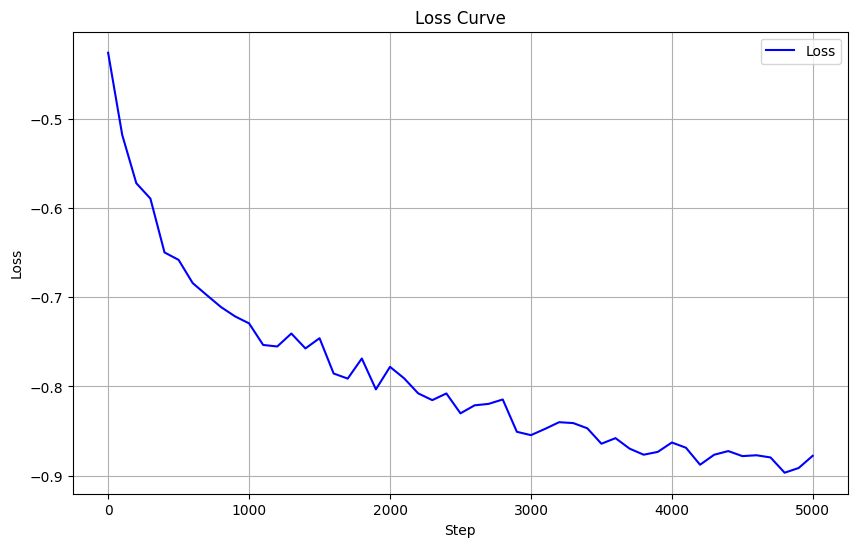

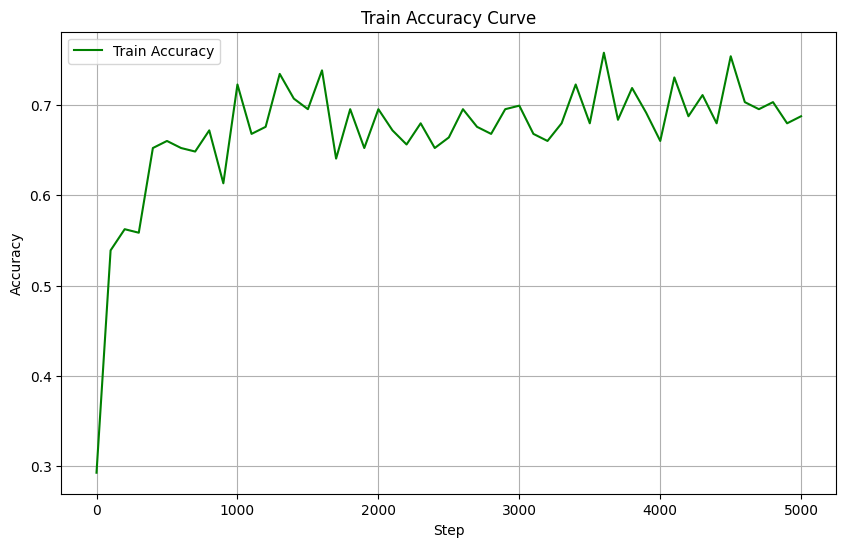

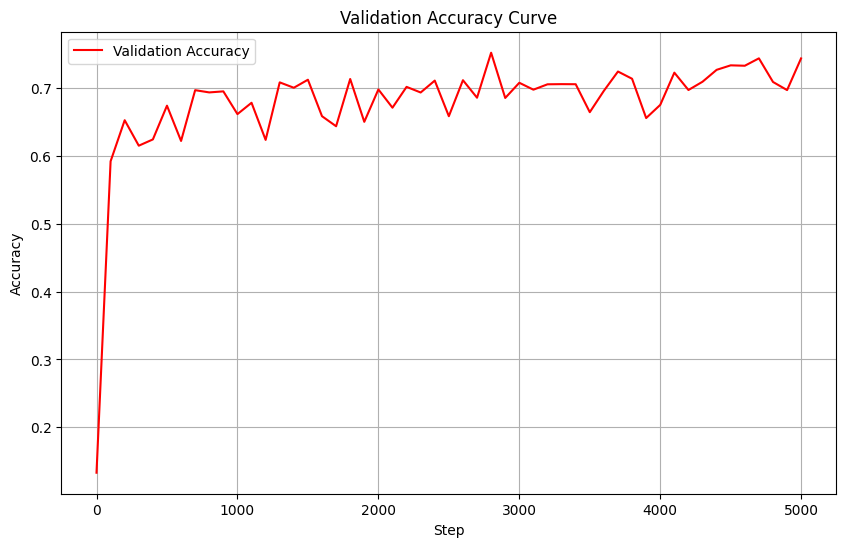

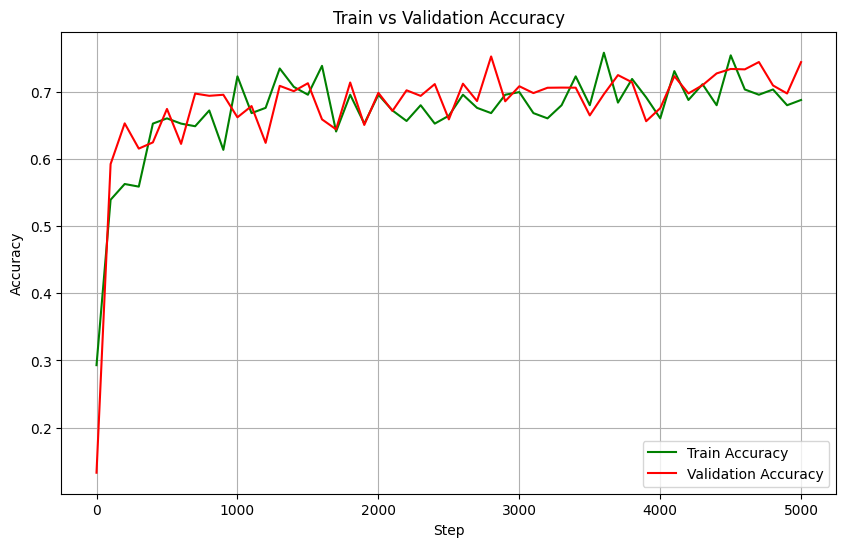

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# 读取日志文件
log_file_path = 'MS_Demo/retrain_logs/training.log'
with open(log_file_path, 'r') as file:
    log_data = file.readlines()

# 解析日志内容
pattern = re.compile(r"Step (\d+): loss = ([\-\d\.]+) train acc = ([\d\.]+) val acc = ([\d\.]+)")
data = []
for line in log_data:
    match = pattern.match(line.strip())
    if match:
        step, loss, train_acc, val_acc = match.groups()
        data.append({
            'Step': int(step),
            'Loss': float(loss),
            'Train Accuracy': float(train_acc),
            'Validation Accuracy': float(val_acc)
        })

# 转换为 DataFrame
df = pd.DataFrame(data)

# 绘制损失值曲线
plt.figure(figsize=(10, 6))
plt.plot(df['Step'], df['Loss'], label='Loss', color='blue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# 绘制训练准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(df['Step'], df['Train Accuracy'], label='Train Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Train Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# 绘制验证准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(df['Step'], df['Validation Accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# 绘制训练准确率与验证准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(df['Step'], df['Train Accuracy'], label='Train Accuracy', color='green')
plt.plot(df['Step'], df['Validation Accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## 遮挡分析工具

下面流程是一个基于 MindSpore 框架的遮挡分析（Occlusion Analysis）工具，主要用于评估输入图像中不同区域对最终分类结果的影响。通过在图像上系统地移动遮挡块（occluding filter），观察目标类别预测概率的变化，并生成对应的热力图，进而与原图融合，直观展示各区域的重要性。

### 主要功能

- **遮挡图像生成**  
  使用 `create_occlusion` 函数，在输入图像（要求尺寸为 512×512）上按照给定遮挡块大小（roi_size）和步长（stride_size），生成一系列带有遮挡效果的图像。这些图像用于后续预测，以观察遮挡对模型预测的影响。

- **图像预处理**  
  `process_image_for_model` 函数将 PIL 格式图像转换为模型输入所需的格式：调整到预期尺寸（例如 299×299），归一化处理，并将图像数据格式转换为 (C, H, W) 的 numpy 数组。

- **模型构建与加载**  
  `build_model` 函数根据训练时使用的逻辑：
  - 加载预训练的 InceptionV3 模型，并构造瓶颈特征提取器。
  - 构建最终的全连接分类层（final_layer）。
  - 通过加载已训练好的 checkpoint 参数，将参数注入最终分类层，并设置模型为评估模式。

- **单图像预测**  
  `predict` 函数先对输入图像进行预处理，再将图像通过瓶颈提取器和最终分类层进行前向计算，最后利用 Softmax 得到每个类别的预测概率。

- **遮挡热力图生成与融合**  
  - 根据原图预测结果确定目标类别（预测概率最高的类别）。  
  - 对每个遮挡图像进行预测，并记录目标类别的概率变化。  
  - 将原图目标概率与遮挡图像预测的目标概率之差构造成热力图，其中差值越大说明该区域对预测结果的影响越大。  
  - 使用 `blend_occlusion_map` 函数，将生成的热力图与原图融合，直观展示不同区域对最终预测结果的贡献。

- **结果保存与展示**  
  代码最终会保存遮挡热力图和融合后的图像，方便用户查看并进一步分析图像中哪些部分对分类起关键作用。

### 流程概述

1. **参数解析与初始化**  
   通过命令行参数（在 Notebook 中可转为直接设置变量）传入图像路径、checkpoint 文件、标签文件、遮挡块大小、步长和输出目录。

2. **模型与标签加载**  
   - 读取标签文件，确定类别数。  
   - 调用 `build_model` 加载模型配置、构造瓶颈提取器与最终层，并加载训练好的参数。

3. **原图处理与初始预测**  
   - 载入原始图像并调整为 512×512 尺寸。  
   - 使用 `predict` 得到原图的预测结果，并确定目标类别（预测最高的类别）。

4. **遮挡图生成与预测**  
   - 使用 `create_occlusion` 在原图上生成一批遮挡图像。  
   - 对每个遮挡图像进行预测，记录目标类别的预测概率。

5. **热力图生成与图像融合**  
   - 计算遮挡热力图：每个遮挡位置的数值为原图目标概率与遮挡图目标概率之差。  
   - 使用 matplotlib 绘制热力图并保存。  
   - 利用 `blend_occlusion_map` 将热力图与原图融合，生成最终的融合图像。

6. **保存结果**  
   将生成的热力图和融合图像保存到指定的输出目录中，并在控制台打印保存路径和完成信息。

通过上述步骤，代码实现了对输入图像进行区域敏感性分析，帮助理解哪些图像区域对分类结果贡献较大，为模型解释性提供了直观的参考。


In [14]:
#%% 导入必要模块
import os
import time
from math import floor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import mindspore as ms
import mindspore.nn as nn
from mindspore.train.serialization import load_checkpoint, load_param_into_net

In [15]:
#%% 定义辅助函数

def create_occlusion(im, roi_size, stride_size):
    """
    对给定 PIL 图像 im（尺寸应为 512x512）创建遮挡图像批次，
    遮挡块大小为 roi_size，步长为 stride_size。
    返回遮挡图像列表以及 grid 的行数（列数相同）。
    """
    iters = int(floor((512 - roi_size + 1) / stride_size))
    batch = []
    for r in range(iters):
        for c in range(iters):
            imOc = im.copy()
            draw = ImageDraw.Draw(imOc)
            left = c * stride_size
            top = r * stride_size
            right = left + roi_size - 1
            bottom = top + roi_size - 1
            draw.rectangle([left, top, right, bottom], fill=(150, 150, 150))
            batch.append(imOc)
    return batch, iters

def process_image_for_model(im, model_config):
    """
    将 PIL 图像转换为模型输入格式：
      - 调整大小到模型所需尺寸（例如 299x299）
      - 转为 numpy 数组、归一化并转置为 (C,H,W)
    """
    input_width = model_config["input_width"]
    input_height = model_config["input_height"]
    input_mean = model_config["input_mean"]
    input_std = model_config["input_std"]
    
    im_resized = im.resize((input_width, input_height))
    img_array = np.array(im_resized).astype(np.float32)
    img_array = (img_array - input_mean) / input_std
    img_array = np.transpose(img_array, (2, 0, 1))
    return img_array

def build_model(ckpt_path, num_classes):
    """
    根据 train.py 中的逻辑构造模型：
      - 加载 MindCV 中预训练的 InceptionV3 模型，并构造瓶颈提取器（bottleneck_extractor）
      - 创建最终分类层（final_layer）
      - 加载 checkpoint 参数到 final_layer
    返回：(bottleneck_extractor, final_layer, model_config)
    """
    model_config = get_model_config()
    dummy_model_dir = "./dummy_model_dir"  # 占位目录
    _, bottleneck_extractor, _ = create_model_graph(model_config, dummy_model_dir)
    
    final_tensor_name = "final_result"  # 与训练时保持一致
    final_layer, _, _ = train_final_layer(num_classes, final_tensor_name,
                                                bottleneck_extractor,
                                                model_config["bottleneck_tensor_size"],
                                                learning_rate=0.001)
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(final_layer, param_dict)
    
    final_layer.set_train(False)
    bottleneck_extractor.set_train(False)
    
    return bottleneck_extractor, final_layer, model_config

def predict(im, bottleneck_extractor, final_layer, model_config):
    """
    对单张图像（PIL格式）进行预测：
      - 预处理图像为模型输入
      - 转换为 Tensor，通过 bottleneck_extractor 提取特征，并经过 final_layer 得到 logits，
      - 使用 softmax 得到概率分布。
    返回一个 numpy 数组，形状为 (num_classes,)
    """
    img_array = process_image_for_model(im, model_config)
    tensor_img = ms.Tensor(np.expand_dims(img_array, axis=0), ms.float32)
    bottleneck = bottleneck_extractor(tensor_img)
    logits = final_layer(bottleneck)
    softmax_op = nn.Softmax()
    probs = softmax_op(logits)
    return probs.asnumpy()[0]

def blend_occlusion_map(orig_im, occlusion_map, blend_alpha=0.4):
    """
    将遮挡热力图与原图融合：
      - 将 occlusion_map 数值归一化至 0~255，
      - 使用 matplotlib 的 colormap（例如 magma）生成伪彩色图像，
      - 与原图融合后返回融合图像。
    """
    norm_map = (occlusion_map - np.min(occlusion_map)) / (np.max(occlusion_map) - np.min(occlusion_map) + 1e-8)
    norm_map = (norm_map * 255).astype(np.uint8)
    cmap = plt.get_cmap("magma")
    colored_map = cmap(norm_map)
    colored_map = (colored_map[:, :, :3] * 255).astype(np.uint8)
    occlusion_im = Image.fromarray(colored_map)
    occlusion_im = occlusion_im.resize(orig_im.size)
    blended = Image.blend(orig_im, occlusion_im, blend_alpha)
    return blended

[ERROR] CORE(546,ffff8e212020,python):2025-03-26-11:39:59.489.709 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_546/2156963446.py]
[WARNING] CORE(546,ffff8e212020,python):2025-03-26-11:39:59.489.760 [mindspore/core/utils/info.cc:121] ToString] The file '/tmp/ipykernel_546/2156963446.py' may not exists.


.原图预测类别: DME 置信度: 0.9486
生成 225 张遮挡图像，grid 大小: 15x15
.处理 50/225 张遮挡图
.处理 100/225 张遮挡图
处理 150/225 张遮挡图
.处理 200/225 张遮挡图


<Figure size 640x480 with 0 Axes>

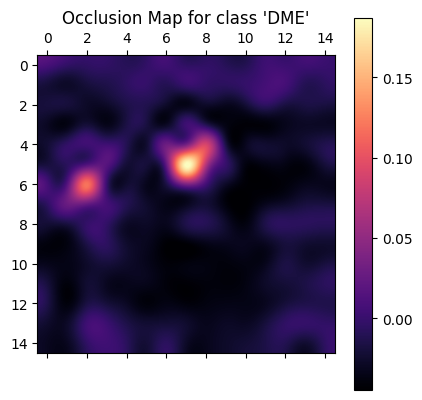

热力图保存至: /home/mindspore/work/MS_Demo/occlusion_map.png
融合图像已保存至: /home/mindspore/work/MS_Demo/Occlusion/DME-1081406-1.jpeg
Occlusion 分析完成。


In [16]:
#%% 设置参数并执行 occlusion 分析

# 设置文件路径（根据你的实际环境修改）
image_file = "/home/mindspore/work/OCT2017/test/DME/DME-1081406-1.jpeg"
ckpt_path = "/home/mindspore/work/MS_Demo/retrained_model.ckpt"
labels_file = "/home/mindspore/work/MS_Demo/output_labels.txt"
roi_size = 32
stride_size = 32
output_dir = "/home/mindspore/work/MS_Demo/Occlusion"

# 加载类别标签
with open(labels_file, "r") as f:
    labels = [line.strip() for line in f.readlines()]
num_classes = len(labels)

# 构建模型（加载瓶颈提取器与最终层）
bottleneck_extractor, final_layer, model_config = build_model(ckpt_path, num_classes)

# 加载图像，并调整为 512x512 用于 occlusion 分析
orig_im = Image.open(image_file).convert("RGB")
im_512 = orig_im.resize((512, 512))

# 对原图进行预测，确定目标类别（取最高置信度）
baseline_probs = predict(im_512, bottleneck_extractor, final_layer, model_config)
target_class = int(np.argmax(baseline_probs))
baseline_target_prob = baseline_probs[target_class]
print("原图预测类别: {} 置信度: {:.4f}".format(labels[target_class], baseline_target_prob))

# 生成遮挡图像批次
occlusion_batch, grid_size = create_occlusion(im_512, roi_size, stride_size)
num_occlusions = len(occlusion_batch)
print("生成 {} 张遮挡图像，grid 大小: {}x{}".format(num_occlusions, grid_size, grid_size))

# 对每个遮挡图像进行预测，提取目标类别的预测概率
occlusion_probs = []
for idx, oc_im in enumerate(occlusion_batch):
    probs = predict(oc_im, bottleneck_extractor, final_layer, model_config)
    occlusion_probs.append(probs[target_class])
    if (idx + 1) % 50 == 0:
        print("处理 {}/{} 张遮挡图".format(idx + 1, num_occlusions))
occlusion_probs = np.array(occlusion_probs)

# 构造遮挡热力图：用 (baseline_target_prob - occluded_prob) 表示预测下降幅度
occlusion_map = np.zeros((grid_size, grid_size), dtype=np.float32)
i = 0
for r in range(grid_size):
    for c in range(grid_size):
        occlusion_map[r, c] = baseline_target_prob - occlusion_probs[i]
        i += 1

# 绘制并保存遮挡热力图
plt.figure()
plt.matshow(occlusion_map, interpolation="lanczos", cmap="magma")
plt.title("Occlusion Map for class '{}'".format(labels[target_class]))
plt.colorbar()
plt.show()
heatmap_path = os.path.join("/home/mindspore/work/MS_Demo", "occlusion_map.png")
plt.savefig(heatmap_path, bbox_inches="tight", pad_inches=0)
plt.close("all")
print("热力图保存至:", heatmap_path)

# 融合原图与遮挡热力图
blended = blend_occlusion_map(orig_im, occlusion_map, blend_alpha=0.4)

# 保存融合图像至指定目录
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, os.path.basename(image_file))
blended.save(output_path)
print("融合图像已保存至:", output_path)
print("Occlusion 分析完成。")

## 参考文献
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

**昇思大模型平台链接**：https://xihe.mindspore.cn/models/STRUGGLE/RetinalEdemaDetection/